In [1]:
# The aim of this notebook is to reproduce the outputs of the following notebook in Pytorch:
# https://www.tensorflow.org/tutorials/structured_data/time_series
# Some of the markdown comments are borrowed from the original notebook.

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from zipfile import ZipFile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#------------------
sys.path.append("..")
from scripts.dataset import TimeSeriesDatasetMature

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
if not os.path.exists('data/jena_climate_2009_2016.csv'):
    !curl -o data/jena_climate_2009_2016.csv.zip https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
    with ZipFile('data/jena_climate_2009_2016.csv.zip', 'r') as zf:
        zf.extractall('data/')

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [4]:
df = pd.read_csv('data/jena_climate_2009_2016.csv')
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

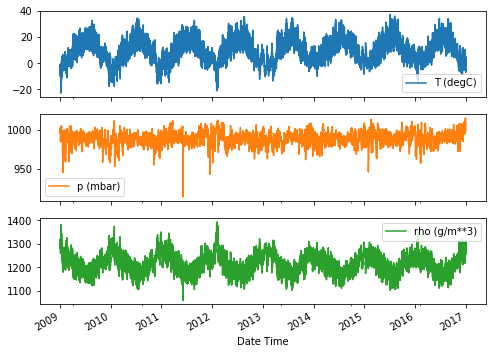

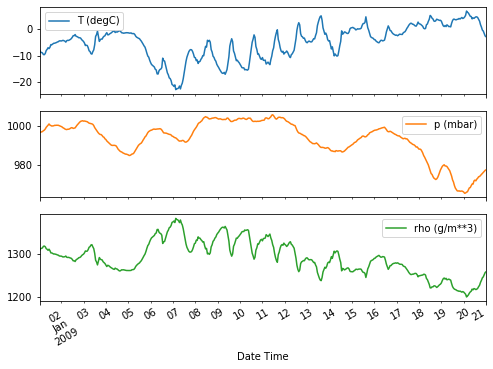

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

This will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [11]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

This gives the model access to the most important frequency features. In this case we knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

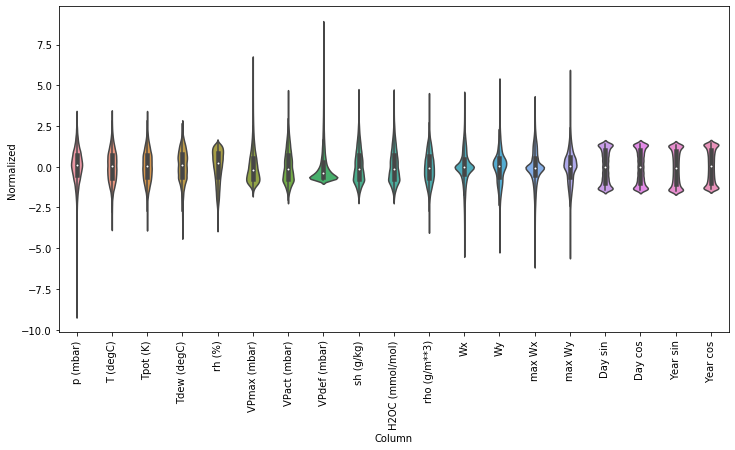

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


# Build the dataset

In [15]:
input_width = 6
label_width = 4
shift = 6
batch_size = 16
feature_columns=['p (mbar)', 'rho (g/m**3)']
label_columns=['T (degC)']

In [16]:
time_Series_dataset = TimeSeriesDatasetMature(train_df, input_width=input_width, label_width=label_width, 
                                              shift=shift, feature_columns=feature_columns,
                                              label_columns=label_columns)
trainloader = DataLoader(time_Series_dataset, batch_size=batch_size, shuffle=True)
len(trainloader)

3066

torch.Size([16, 12, 2]) torch.Size([16, 6, 1]) torch.Size([16, 4, 1])


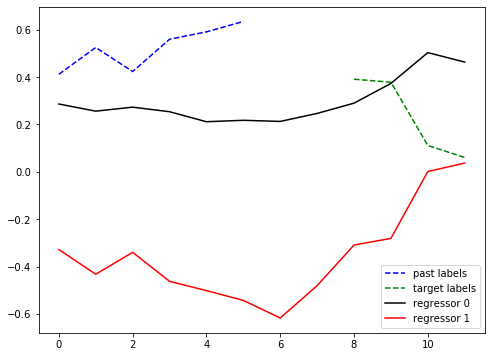

In [17]:
window_size = input_width + shift
(signal, past_labels, targets) = next(iter(trainloader))
print(signal.size(), past_labels.size(), targets.size())
sample_idx = 0
# plot the past labels in the sample [sample_idx] from the minibatch
plt.plot(range(0, input_width), past_labels[sample_idx].data.numpy(), 
         color='b', linestyle='dashed', label='past labels')
# plot the target label in the sample sample_idx from the minibatch
plt.plot(range(window_size - label_width, window_size), targets[sample_idx].data.numpy(), 
         color='g', linestyle='dashed', label='target labels')
# plot some other extra regressors
plt.plot(signal[sample_idx, :, 0].view(-1).data.numpy(), color='k', label='regressor 0')  
plt.plot(signal[sample_idx, :, 1].view(-1).data.numpy(), color='r', label='regressor 1')   
plt.legend();

# Forecating Models

## Many-to-Many mapping using Conv1D and Linear layers

In [18]:
class TSA_many_to_many_conv(nn.Module):
    def __init__(self, label_width):
        super().__init__()
        layers = []
        layers.append(nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1))
        layers.append(nn.ReLU6())
        layers.append(nn.BatchNorm1d(32))
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Flatten(1))
        layers.append(nn.Linear(in_features=384, out_features=32))  # 384: 32*12 which is the size of the output of the previous layer
        layers.append(nn.ReLU6())
        layers.append(nn.BatchNorm1d(32))
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Linear(in_features=32, out_features=label_width))
        self.net = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.net:
#             print(layer, x.shape)
#             import pdb; pdb.set_trace()
            x = layer(x)
        return x

### Training the above model on the training set

In [20]:
model = TSA_many_to_many_conv(label_width)
lr = 0.001
wd = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

loss_vec = []
reset_loss_every = 300
n_epochs = 2
device = "cpu"

model.to(device)
model.train()

window_size = input_width + shift

for epoch in range(n_epochs+1):
    loss_epoch = 0
    num_samples = 0

    for it, (signal, past_labels, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        signal_reshaped = signal.permute(0, 2, 1)  # Input to Cnov1d should be of size: (B, channels, length). 
        # Here channels is in fact number of features/regressors amd length is size of the signal passed into the conv.
        output = model(signal_reshaped.float().to(device))
        targets = targets.view(output.size()[0], -1).float().to(device)
        loss = F.mse_loss(output, targets)
        num_samples += output.size()[0]
        loss_epoch += loss.item() * output.size()[0]
        loss.backward()
        optimizer.step()
        
        if (it % reset_loss_every) == 0:
            print(f"epoch: {epoch}, it: {it}, average_loss: {loss_epoch/num_samples}")
            loss_epoch = 0
            num_samples = 0

#     print(f"epoch: {epoch}, num_samples: {num_samples}, average_loss: {loss_epoch / num_samples}")

    if (epoch % (n_epochs//2)) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

# Save the model and weights
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, './weights/weights_many_to_many_conv.pth')

epoch: 0, it: 0, average_loss: 2.1553869247436523
epoch: 0, it: 300, average_loss: 0.16083348708227277
epoch: 0, it: 600, average_loss: 0.12118867868557573
epoch: 0, it: 900, average_loss: 0.10919819515819351
epoch: 0, it: 1200, average_loss: 0.10228897711882988
epoch: 0, it: 1500, average_loss: 0.08824990938107173
epoch: 0, it: 1800, average_loss: 0.09050802572009464
epoch: 0, it: 2100, average_loss: 0.08413082133357723
epoch: 0, it: 2400, average_loss: 0.08490072376094758
epoch: 0, it: 2700, average_loss: 0.08768972884553174
epoch: 0, it: 3000, average_loss: 0.08768642552817861
epoch: 1, it: 0, average_loss: 0.034091684967279434
epoch: 1, it: 300, average_loss: 0.08632100862140457
epoch: 1, it: 600, average_loss: 0.08736035521763066
epoch: 1, it: 900, average_loss: 0.08699230705698331
epoch: 1, it: 1200, average_loss: 0.07741587386156122
epoch: 1, it: 1500, average_loss: 0.08812321460961053
epoch: 1, it: 1800, average_loss: 0.08623780394904315
epoch: 1, it: 2100, average_loss: 0.0930

/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TSA_many_to_many_conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Evaluation on the validation set

In [21]:
time_Series_dataset_valid = TimeSeriesDatasetMature(val_df, input_width=input_width, label_width=label_width, 
                                              shift=shift, feature_columns=feature_columns,
                                              label_columns=label_columns)
validloader = DataLoader(time_Series_dataset_valid, batch_size=batch_size, shuffle=True)
len(validloader)

876

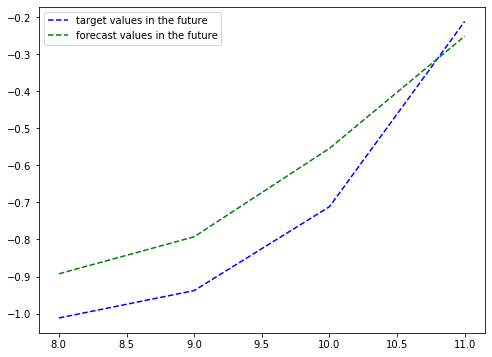

In [22]:
model.to(device)
model.eval()

window_size = input_width + shift

for it, (signal, past_labels, targets) in enumerate(validloader):
    signal_reshaped = signal.permute(0, 2, 1) 
    output = model(signal_reshaped.float().to(device))
    targets = targets.view(output.size()[0], -1).float().to(device)
    loss = F.mse_loss(output, targets)
    num_samples += output.size()[0]
    loss_epoch += loss.item() * output.size()[0]
    
    plt.plot(range(window_size - label_width, window_size), targets[0].view(-1).data.numpy(), 
         color='b', linestyle='dashed', label='target values in the future')  
    plt.plot(range(window_size - label_width, window_size), output[0].view(-1).data.numpy(), 
         color='g', linestyle='dashed', label='forecast values in the future')
    plt.legend();
    break

### Multiple inputs to the model.forward(self, x1, x2), where x1 is composed of the regressors, and x2 is the previous targets.

### Use LSTM for Many-to-Many mapping.

### Use AutoRegressive method

### Denser model with two layers of Conv1d

### Simultaneously forecast multiple signals

Using https://louisenaud.github.io/time_series_prediction.html ?